In [1]:
#import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ['CUDA_VISIBLE_DEVICES'] = '1,3'
#import tensorflow
#tensorflow.test.gpu_device_name()

'/device:GPU:0'

In [1]:
import tensorflow.keras
from tensorflow.keras import layers

In [2]:
# is keras present?
tensorflow.keras

<module 'tensorflow.keras' from '/usr/local/lib/python3.5/dist-packages/tensorflow/keras/__init__.py'>

In [3]:
import os
import pandas
import numpy
from sklearn.metrics import confusion_matrix

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
SAMPLES = 400

### Load data

In [7]:
data_path = os.path.join('..','data','dataset_timeseries_3ch.txt')

In [8]:
df = pandas.read_csv(data_path, sep=';')
df = df.drop('Unnamed: 6', axis=1)

In [9]:
df.head()

,receptor_id,class,nsamp_per_chan,chan_E_samples,chan_N_samples,chan_Z_samples
0,0,0,400,"0.29495,0.41152,0.71334,1.19304,1.72107,2.1319...","0.49177,0.56177,0.84997,1.38184,1.99726,2.4611...","0.15294,0.15589,0.04885,-0.17813,-0.44809,-0.6..."
1,1,0,400,"0.08697,-0.05178,-0.40827,-0.97186,-1.58907,-2...","-0.18031,-0.43404,-0.76179,-1.16899,-1.57189,-...","0.17619,0.10835,-0.06327,-0.31164,-0.58474,-0...."
2,2,0,400,"-0.79922,-1.26171,-1.40667,-1.2125,-0.85398,-0...","2.36226,2.64067,2.76791,2.76611,2.66017,2.4915...","0.47433,-0.35791,-1.11644,-1.72523,-2.2055,-2...."
3,3,0,400,"0.04591,0.04574,-0.24254,-0.82716,-1.52647,-2....","-0.12581,-0.32034,-0.80886,-1.67523,-2.67637,-...","-0.56093,-0.61042,-0.84127,-1.33623,-1.92725,-..."
4,4,3,400,"0.10673,-0.11991,-0.68573,-1.618,-2.67277,-3.5...","-0.18146,-0.25581,-0.55374,-1.0699,-1.64551,-2...","-0.07987,-0.1264,-0.24434,-0.42169,-0.60204,-0..."


In [10]:
df.columns

Index(['receptor_id', ' class', ' nsamp_per_chan', ' chan_E_samples',
       ' chan_N_samples', ' chan_Z_samples'],
      dtype='object')

In [11]:
# trip column names of possible spaces
df = df.rename(index=str, columns={x: x.strip() for x in df.columns})

In [12]:
# shuffle dataframe rows
df = df.sample(frac=1).reset_index(drop=True)

In [13]:
[x for x in df.columns]

['receptor_id',
 'class',
 'nsamp_per_chan',
 'chan_E_samples',
 'chan_N_samples',
 'chan_Z_samples']

In [14]:
print(df['chan_E_samples'].shape)
print(df['chan_N_samples'].shape)
print(df['chan_Z_samples'].shape)

(353869,)
(353869,)
(353869,)


In [15]:
N = df['chan_E_samples'].shape[0]

In [16]:
CHAN_CODES = {'E': 0, 'N': 1, 'Z': 2}
CLASS_CODES = {'N': 0, 'S': 1, 'P': 2, 'T': 3}

In [17]:
data_X = numpy.zeros((N, SAMPLES, 3))  # number of cases, length of a sigle case, number of channels
data_Y = df['class'].values

In [18]:
# test of conversion function expression
numpy.array(list(map(float, df['chan_E_samples'][0].split(',')))).shape

(400,)

In [38]:
for i in range(N):
    data_X[i,:,CHAN_CODES['E']] = numpy.array(list(map(float, df['chan_E_samples'][i].split(','))))[:]
    data_X[i,:,CHAN_CODES['N']] = numpy.array(list(map(float, df['chan_N_samples'][i].split(','))))[:]
    data_X[i,:,CHAN_CODES['Z']] = numpy.array(list(map(float, df['chan_Z_samples'][i].split(','))))[:]    

In [39]:
data_X.shape

(353869, 400, 3)

In [40]:
print(data_Y.shape, data_Y.min(), data_Y.max())

(353869,) 0 3


In [41]:
import scipy.io
scipy.io.savemat('dataset', {'data_X': data_X,
                             'data_Y': data_Y}, do_compression=False)

#### Load data from a *.mat file

In [6]:
import scipy.io
d = scipy.io.loadmat('dataset')
data_X = d['data_X']
data_Y = d['data_Y'].ravel()

In [7]:
#shuffle both X and Y
permuted_indices = numpy.random.permutation(data_X.shape[0])
data_X = data_X[permuted_indices]
data_Y = data_Y[permuted_indices]
print(data_X.shape, data_Y.shape, data_Y.min(), data_Y.max())

(353869, 400, 3) (353869,) 0 3


In [8]:
data_X.shape, data_Y.shape

((353869, 400, 3), (353869,))

In [9]:
# just a test...
print(numpy.abs(data_X[0,:,0]).max(),numpy.abs(data_X[0,:,1]).max(),numpy.abs(data_X[0,:,2]).max())
print(data_X[0,:,0].shape)

7.75483 10.43202 25.09388
(400,)


In [11]:
means_in_channels = numpy.mean(data_X, axis=1, keepdims=True)

data_X_norm = (data_X - means_in_channels)

max_in_channels = numpy.max(numpy.max(numpy.abs(data_X_norm), axis=1, keepdims=True), axis=2, keepdims=True)

###data_X_norm /= max_in_channels

print(means_in_channels.shape, max_in_channels.shape)

(353869, 1, 3) (353869, 1, 1)


In [12]:
# is it nozmalized correctly?
print(data_X_norm.min(), data_X_norm.max())

-292995.634865 274443.242064


0


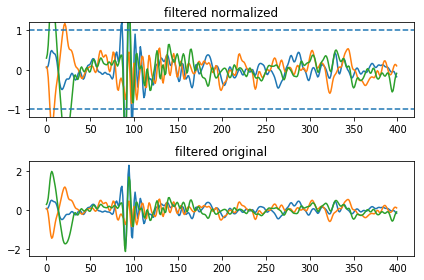

In [58]:
index = 30566

fig = plt.figure()
ax = fig.add_subplot(211)
ax.plot(data_X_norm[index,:,0])
ax.plot(data_X_norm[index,:,1])
ax.plot(data_X_norm[index,:,2])
ax.axhline(-1, linestyle='--')
ax.axhline(1, linestyle='--')
ax.set_ylim(-1.2,1.2)
ax.set_title('filtered normalized')

ax = fig.add_subplot(212)
ax.plot(data_X[index,:,0])
ax.plot(data_X[index,:,1])
ax.plot(data_X[index,:,2])
ax.set_title('filtered original')

plt.tight_layout()
print(data_Y[index])

In [164]:
CLASS_CODES = {'N': 0, 'S': 1, 'P': 2, 'T': 3}
data_X_N = data_X_norm[data_Y == CLASS_CODES['N'],:,:]
data_X_S = data_X_norm[data_Y == CLASS_CODES['S'],:,:]
data_X_P = data_X_norm[data_Y == CLASS_CODES['P'],:,:]
data_X_T = data_X_norm[data_Y == CLASS_CODES['T'],:,:]
print(data_X_N.shape, data_X_S.shape, data_X_P.shape, data_X_T.shape)

(268103, 400, 3) (1113, 400, 3) (6364, 400, 3) (78289, 400, 3)


In [165]:
data_Y

array([3, 0, 0, ..., 0, 0, 3])

In [166]:
# split test/train by count
test_num = 200  # we take the first test_num samples for test
N_train_tot = data_X_N[test_num:].shape[0]
S_train_tot = data_X_S[test_num:].shape[0]
P_train_tot = data_X_P[test_num:].shape[0]
T_train_tot = data_X_T[test_num:].shape[0]

train_X = numpy.vstack((data_X_N[test_num:], 
                        data_X_S[test_num:],
                        data_X_P[test_num:],
                        data_X_T[test_num:]))

train_Y = numpy.hstack((numpy.ones(N_train_tot)*CLASS_CODES['N'],
                        numpy.ones(S_train_tot)*CLASS_CODES['S'],
                        numpy.ones(P_train_tot)*CLASS_CODES['P'],
                        numpy.ones(T_train_tot)*CLASS_CODES['T']))

test_X = numpy.vstack((data_X_N[:test_num], 
                       data_X_S[:test_num],
                       data_X_P[:test_num],
                       data_X_T[:test_num]))

test_Y = numpy.hstack((numpy.ones(test_num)*CLASS_CODES['N'],
                       numpy.ones(test_num)*CLASS_CODES['S'],
                       numpy.ones(test_num)*CLASS_CODES['P'],
                       numpy.ones(test_num)*CLASS_CODES['T']))

train_tot  = train_X.shape[0]

In [ ]:
# split test/train by a ratio
"""
test_frac = 0.1  # we take the first test_num samples for test
N_test_tot = round(data_X_N.shape[0] * test_frac)
S_test_tot = round(data_X_S.shape[0] * test_frac)
P_test_tot = round(data_X_P.shape[0] * test_frac)
T_test_tot = round(data_X_T.shape[0] * test_frac)

train_frac = 1-test_frac  # we take the first test_num samples for test
N_train_tot = round(data_X_N.shape[0] * train_frac)
S_train_tot = round(data_X_S.shape[0] * train_frac)
P_train_tot = round(data_X_P.shape[0] * train_frac)
T_train_tot = round(data_X_T.shape[0] * train_frac)

# check if we have all cases
assert N_train_tot+N_test_tot == data_X_N.shape[0]
assert S_train_tot+S_test_tot == data_X_S.shape[0]
assert P_train_tot+P_test_tot == data_X_P.shape[0]
assert T_train_tot+T_test_tot == data_X_T.shape[0]

train_X = numpy.vstack((data_X_N[N_test_tot:], 
                        data_X_S[S_test_tot:],
                        data_X_P[P_test_tot:],
                        data_X_T[T_test_tot:]))

train_Y = numpy.hstack((numpy.ones(N_train_tot)*CLASS_CODES['N'],
                        numpy.ones(S_train_tot)*CLASS_CODES['S'],
                        numpy.ones(P_train_tot)*CLASS_CODES['P'],
                        numpy.ones(T_train_tot)*CLASS_CODES['T']))

test_X = numpy.vstack((data_X_N[:N_test_tot], 
                       data_X_S[:S_test_tot],
                       data_X_P[:P_test_tot],
                       data_X_T[:T_test_tot]))

test_Y = numpy.hstack((numpy.ones(N_test_tot)*CLASS_CODES['N'],
                       numpy.ones(S_test_tot)*CLASS_CODES['S'],
                       numpy.ones(P_test_tot)*CLASS_CODES['P'],
                       numpy.ones(T_test_tot)*CLASS_CODES['T']))

train_tot  = train_X.shape[0]
"""

In [167]:
# let's shuffle train data - both X and Y in the same way
indices = numpy.random.permutation(train_tot)
train_X = numpy.take(train_X, indices, axis=0)
train_Y = numpy.take(train_Y, indices, axis=0)

In [168]:
# one-hot encoding of train_Y/test_Y
from tensorflow.keras.utils import to_categorical
train_Y_cat = to_categorical(train_Y)
test_Y_cat = to_categorical(test_Y)

In [169]:
# let's review tensor shapes
print(train_X.shape, train_Y.shape)
print(test_X.shape, test_Y.shape)

(353069, 400, 3) (353069,)
(800, 400, 3) (800,)


In [170]:
WIGHTS_CONST = 1000.

class_weight = {CLASS_CODES['N']: 0.05, #1./N_train_tot * WIGHTS_CONST, 
                CLASS_CODES['S']: 50,#./S_train_tot * WIGHTS_CONST, 
                CLASS_CODES['P']: 5, #1./P_train_tot * WIGHTS_CONST , 
                CLASS_CODES['T']: 1} #./T_train_tot * WIGHTS_CONST}

#class_weight = {CLASS_CODES['N']: 1./N_train_tot * WIGHTS_CONST, 
#                CLASS_CODES['S']: 1./S_train_tot * WIGHTS_CONST, 
#                CLASS_CODES['P']:  1./P_train_tot * WIGHTS_CONST , 
#                CLASS_CODES['T']:   1./T_train_tot * WIGHTS_CONST}

class_weight

{0: 0.05, 1: 50, 2: 5, 3: 1}

## Network

In [171]:
num_classes = len(CLASS_CODES)

#### Let's build the model

In [172]:
model = tensorflow.keras.Sequential()

model.add(layers.Conv1D(100, 10, input_shape=(SAMPLES, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv1D(100, 10))
#model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Dropout(0.35))

model.add(layers.Conv1D(100, 10))
#model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(3)) 
model.add(layers.GlobalAveragePooling1D())
#model.add(layers.Dropout(0.35))

model.add(layers.Flatten())
model.add(layers.Dense(32))
#model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 391, 100)          3100      
_________________________________________________________________
batch_normalization_5 (Batch (None, 391, 100)          400       
_________________________________________________________________
activation_20 (Activation)   (None, 391, 100)          0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 382, 100)          100100    
_________________________________________________________________
activation_21 (Activation)   (None, 382, 100)          0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 127, 100)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 127, 100)          0         
__________

In [173]:
train_Y.shape

(353069,)

In [174]:
from tensorflow.keras.utils import multi_gpu_model
#model_gpu = multi_gpu_model(model, gpus=2)

#model_gpu.compile(loss='categorical_crossentropy',
#              optimizer='adam', 
#              metrics=['accuracy'])

model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

In [175]:
callbacks_list = [
    #tensorflow.keras.callbacks.ModelCheckpoint(
    #    filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
    #    monitor='val_loss', save_best_only=True),
    #tensorflow.keras.callbacks.EarlyStopping(monitor='acc', patience=2)
]

In [176]:
tot_hist = []

In [183]:
history = model.fit(train_X,  
                        train_Y_cat,
                        batch_size=128,
                        epochs=50,
                        #callbacks=callbacks_list,
                        validation_split=0.2,
                        verbose=1,
                        class_weight=class_weight,                    
                        #validation_data = (test_X, test_Y_cat)
                       )

tot_hist.append(history)

Train on 282455 samples, validate on 70614 samples
Epoch 1/50
282455/282455 [==============================] - 39s 137us/step - loss: 0.2638 - acc: 0.5215 - val_loss: 0.3868 - val_acc: 0.2001
Epoch 2/50
282455/282455 [==============================] - 39s 137us/step - loss: 0.2535 - acc: 0.5274 - val_loss: 0.4295 - val_acc: 0.2090
Epoch 3/50
282455/282455 [==============================] - 39s 139us/step - loss: 0.2591 - acc: 0.5183 - val_loss: 0.4226 - val_acc: 0.2072
Epoch 4/50
282455/282455 [==============================] - 39s 139us/step - loss: 0.2611 - acc: 0.5164 - val_loss: 0.4415 - val_acc: 0.2078
Epoch 5/50
282455/282455 [==============================] - 39s 138us/step - loss: 0.2877 - acc: 0.5248 - val_loss: 0.3859 - val_acc: 0.2043
Epoch 6/50
282455/282455 [==============================] - 39s 137us/step - loss: 0.2640 - acc: 0.5132 - val_loss: 0.3562 - val_acc: 0.2202
Epoch 7/50
282455/282455 [==============================] - 39s 137us/step - loss: 0.2648 - acc: 0.5232

In [184]:
#model_gpu.evaluate(test_X, test_Y_cat)
model.evaluate(test_X, test_Y_cat)

800/800 [==============================] - 0s 255us/step


[1.1372120046615601, 0.54000000000000004]

In [116]:
model.save_weights('./weights_78_on_test.h5')

ImportError: `save_weights` requires h5py when saving in hdf5.

In [113]:
%ls

1D_conv.ipynb  dataset.mat  weights_78_on_test.data-00000-of-00001
checkpoint     recc.ipynb   weights_78_on_test.index


In [125]:
print('Test:')
pred_test_Y = model.predict(test_X)
pred_test_Y = numpy.argmax(pred_test_Y, axis=1)# where(pred_Y < 0.5, 0, 1)
print(confusion_matrix(pred_test_Y, test_Y))

print('Train:')
pred_train_Y = model.predict(train_X)
pred_train_Y = numpy.argmax(pred_train_Y, axis=1)# where(pred_Y < 0.5, 0, 1)
print(confusion_matrix(pred_train_Y, train_Y))

Test:
[[135   9   3   3]
 [ 23 164   0  13]
 [  8   5 153  15]
 [ 34  22  44 169]]
Train:
[[172200      8     35    998]
 [ 38391    878     31   3095]
 [  5923      2   5820   4733]
 [ 51389     25    278  69263]]


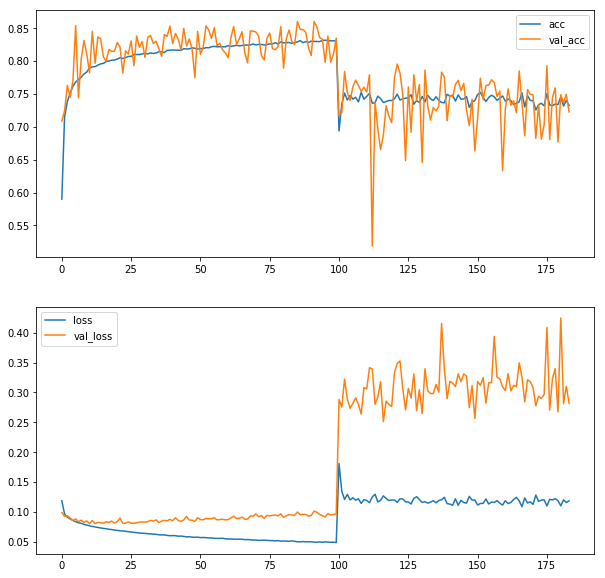

In [124]:
acc = []
loss = []
val_acc = []
val_loss = []
models = []

plot_to = -1

for h in tot_hist:
    acc += h.history['acc']
    loss += h.history['loss']
    val_acc += h.history['val_acc']
    val_loss += h.history['val_loss']
    models.append(h.model)
    
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(211)
ax.plot(acc[:plot_to], label='acc')
ax.plot(val_acc[:plot_to], label='val_acc')
plt.legend()

ax = fig.add_subplot(212)
ax.plot(loss[:plot_to], label='loss')
ax.plot(val_loss[:plot_to], label='val_loss')

plt.legend()


In [48]:
history.model

In [118]:
model.evaluate(test_X, test_Y_cat)

800/800 [==============================] - 0s 97us/step


[0.62688499927520747, 0.78000000000000003]

In [51]:
test_Y.shape

(400,)

In [52]:
import copy
history_1000 = copy.copy(history)

In [53]:
history_1000 is history

False

## another model

In [126]:
model1 = tensorflow.keras.Sequential()

model1.add(layers.Conv1D(60, 20, input_shape=(SAMPLES, 3)))
model1.add(layers.BatchNormalization())
model1.add(layers.Activation('relu'))
model1.add(layers.Conv1D(60, 20))
#model.add(layers.BatchNormalization())
model1.add(layers.Activation('relu'))
model1.add(layers.MaxPooling1D(3))
model1.add(layers.Dropout(0.35))

model1.add(layers.Conv1D(60, 20))
#model.add(layers.BatchNormalization())
model1.add(layers.Activation('relu'))
model1.add(layers.MaxPooling1D(3)) 
model1.add(layers.GlobalAveragePooling1D())
#model.add(layers.Dropout(0.35))

model1.add(layers.Flatten())
model1.add(layers.Dense(32))
#model.add(layers.BatchNormalization())
model1.add(layers.Activation('relu'))
model1.add(layers.Dense(num_classes, activation='softmax'))

print(model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 381, 60)           3660      
_________________________________________________________________
batch_normalization_3 (Batch (None, 381, 60)           240       
_________________________________________________________________
activation_12 (Activation)   (None, 381, 60)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 362, 60)           72060     
_________________________________________________________________
activation_13 (Activation)   (None, 362, 60)           0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 120, 60)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 120, 60)           0         
__________

In [127]:
model1.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

In [151]:
class_weights_1 = {CLASS_CODES['N']: 0.05, #1./N_train_tot * WIGHTS_CONST, 
                CLASS_CODES['S']: 50,#./S_train_tot * WIGHTS_CONST, 
                CLASS_CODES['P']: 5, #1./P_train_tot * WIGHTS_CONST , 
                CLASS_CODES['T']: 1} #./T_train_tot * WIGHTS_CONST}
# optimal [  0.32947466  96.67825849  14.31980045   1.13034166]
print(class_weights_1)

{0: 0.05, 1: 50, 2: 5, 3: 1}


In [131]:
tot_hist_1 = []

In [156]:
history = model1.fit(train_X,  
                    train_Y_cat,
                    batch_size=128,
                    epochs=10,
                    #callbacks=callbacks_list,
                    validation_split=0.2,
                    verbose=1,
                    class_weight=class_weights_1,                    
                    )

tot_hist_1.append(history)

Train on 282455 samples, validate on 70614 samples
Epoch 1/10
282455/282455 [==============================] - 29s 102us/step - loss: 0.1763 - acc: 0.6564 - val_loss: 0.2202 - val_acc: 0.6187
Epoch 2/10
282455/282455 [==============================] - 29s 103us/step - loss: 0.1768 - acc: 0.6535 - val_loss: 0.2216 - val_acc: 0.6224
Epoch 3/10
282455/282455 [==============================] - 29s 102us/step - loss: 0.1695 - acc: 0.6646 - val_loss: 0.2559 - val_acc: 0.6686
Epoch 4/10
282455/282455 [==============================] - 29s 104us/step - loss: 0.1744 - acc: 0.6541 - val_loss: 0.2472 - val_acc: 0.6924
Epoch 5/10
282455/282455 [==============================] - 29s 103us/step - loss: 0.1732 - acc: 0.6695 - val_loss: 0.2292 - val_acc: 0.5895
Epoch 6/10
282455/282455 [==============================] - 29s 103us/step - loss: 0.1717 - acc: 0.6563 - val_loss: 0.2300 - val_acc: 0.6472
Epoch 7/10
282455/282455 [==============================] - 30s 106us/step - loss: 0.1700 - acc: 0.6730

In [157]:
model1.evaluate(test_X, test_Y_cat)

800/800 [==============================] - 0s 256us/step


[0.68353803157806392, 0.77000000000000002]

In [158]:
print('Test:')
pred_test_Y = model1.predict(test_X)
pred_test_Y = numpy.argmax(pred_test_Y, axis=1)# where(pred_Y < 0.5, 0, 1)
print(confusion_matrix(pred_test_Y, test_Y))

print('Train:')
pred_train_Y = model1.predict(train_X)
pred_train_Y = numpy.argmax(pred_train_Y, axis=1)# where(pred_Y < 0.5, 0, 1)
print(confusion_matrix(pred_train_Y, train_Y))

Test:
[[129  10   2   4]
 [ 23 169   1  11]
 [ 13   5 141   8]
 [ 35  16  56 177]]
Train:
[[174005     13     69   1678]
 [ 33966    877     47   2875]
 [  7574      4   4710   3758]
 [ 52358     19   1338  69778]]


## another model with different weight classes

In [139]:
model2 = tensorflow.keras.Sequential()

model2.add(layers.Conv1D(60, 20, input_shape=(SAMPLES, 3)))
model2.add(layers.BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.Conv1D(60, 20))
#model.add(layers.BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.MaxPooling1D(3))
model2.add(layers.Dropout(0.35))

model2.add(layers.Conv1D(60, 20))
#model.add(layers.BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.MaxPooling1D(3)) 
model2.add(layers.GlobalAveragePooling1D())
#model.add(layers.Dropout(0.35))

model2.add(layers.Flatten())
model2.add(layers.Dense(32))
#model.add(layers.BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.Dense(num_classes, activation='softmax'))

print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 381, 60)           3660      
_________________________________________________________________
batch_normalization_4 (Batch (None, 381, 60)           240       
_________________________________________________________________
activation_16 (Activation)   (None, 381, 60)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 362, 60)           72060     
_________________________________________________________________
activation_17 (Activation)   (None, 362, 60)           0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 120, 60)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 120, 60)           0         
__________

In [141]:
model2.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

In [150]:
#optimum class weighjts from keras
from sklearn.utils import class_weight
class_weights_2 = class_weight.compute_class_weight('balanced', numpy.unique(train_Y), train_Y)
print(class_weights_2)

[  0.32947466  96.67825849  14.31980045   1.13034166]


In [142]:
tot_hist_2 = []

In [147]:
history = model2.fit(train_X,  
                    train_Y_cat,
                    batch_size=128,
                    epochs=10,
                    #callbacks=callbacks_list,
                    validation_split=0.2,
                    verbose=1,
                    class_weight=class_weights_2,                    
                    )

tot_hist_2.append(history)

Train on 282455 samples, validate on 70614 samples
Epoch 1/10
282455/282455 [==============================] - 29s 102us/step - loss: 0.1876 - acc: 0.9313 - val_loss: 0.1904 - val_acc: 0.9310
Epoch 2/10
282455/282455 [==============================] - 29s 102us/step - loss: 0.1854 - acc: 0.9323 - val_loss: 0.1890 - val_acc: 0.9317
Epoch 3/10
282455/282455 [==============================] - 28s 101us/step - loss: 0.1841 - acc: 0.9332 - val_loss: 0.1971 - val_acc: 0.9304
Epoch 4/10
282455/282455 [==============================] - 29s 102us/step - loss: 0.1823 - acc: 0.9335 - val_loss: 0.1929 - val_acc: 0.9306
Epoch 5/10
282455/282455 [==============================] - 28s 101us/step - loss: 0.1808 - acc: 0.9340 - val_loss: 0.2041 - val_acc: 0.9270
Epoch 6/10
282455/282455 [==============================] - 29s 102us/step - loss: 0.1787 - acc: 0.9348 - val_loss: 0.1901 - val_acc: 0.9315
Epoch 7/10
282455/282455 [==============================] - 29s 103us/step - loss: 0.1773 - acc: 0.9355

In [148]:
model2.evaluate(test_X, test_Y_cat)

800/800 [==============================] - 0s 204us/step


[1.2835234686732293, 0.5625]